<a href="https://colab.research.google.com/github/Hanbin-git/kaggle/blob/main/test_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torchvision import transforms
from torchvision.transforms import functional as TF

In [3]:
# ===== 설정 =====
test_csv_path = '/content/drive/MyDrive/open/test.csv'
test_img_dir = '/content/drive/MyDrive/open/test'  # test 이미지 폴더
save_root = '/content/drive/MyDrive/fuck/preprocessed_test'  # test 전처리 저장 위치
os.makedirs(save_root, exist_ok=True)

In [4]:

# Grayscale + Resize transform 정의
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        pad_left = (max_wh - w) // 2
        pad_top = (max_wh - h) // 2
        padding = (pad_left, pad_top, max_wh - w - pad_left, max_wh - h - pad_top)
        return TF.pad(image, padding, fill=0)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    SquarePad(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [5]:

# ===== Test CSV 읽기 =====
test_df = pd.read_csv(test_csv_path)

# ✅ 수정된 부분: img_path에서 파일명만 추출
test_df['img_path'] = test_df['img_path'].apply(lambda x: os.path.basename(x))
test_df['full_img_path'] = test_df['img_path'].apply(lambda x: os.path.join(test_img_dir, x))
test_df['img_name_no_ext'] = test_df['img_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])  # 'TEST_00000'

# ===== 전처리 시작 =====
counter = 0  # 전체 이미지 카운터
batch_index = 0  # batch_000, batch_001...
batch_limit = 800  # 한 폴더에 저장할 최대 개수

current_batch_dir = os.path.join(save_root, f"batch_{batch_index:03}")
os.makedirs(current_batch_dir, exist_ok=True)

print("📦 Test 전처리 시작...")

for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = row['img_name_no_ext']  # TEST_00000
    img_path = row['full_img_path']

    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)

        # 폴더 분할 조건
        if counter > 0 and counter % batch_limit == 0:
            batch_index += 1
            current_batch_dir = os.path.join(save_root, f"batch_{batch_index:03}")
            os.makedirs(current_batch_dir, exist_ok=True)

        # 저장 파일명: TEST_00000.npy
        save_name = f"{img_id}.npy"
        save_path = os.path.join(current_batch_dir, save_name)
        np.save(save_path, img_tensor.numpy())

        counter += 1

    except Exception as e:
        print(f"❌ 오류: {img_path} → {e}")

print(f"✅ Test 전처리 완료: 총 {counter}개 이미지 저장됨")
print(f"📂 배치 폴더 수: {batch_index + 1}")

📦 Test 전처리 시작...


100%|██████████| 8258/8258 [33:29<00:00,  4.11it/s]

✅ Test 전처리 완료: 총 8258개 이미지 저장됨
📂 배치 폴더 수: 11


✅ 불러온 이미지 shape: (1, 384, 384)


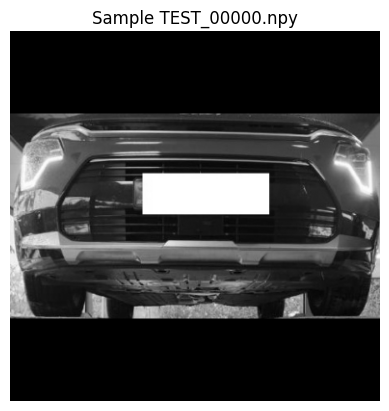

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 예시로 하나 불러오기 (batch_000 폴더에서 첫 파일)
sample_npy_path = '/content/drive/MyDrive/fuck/preprocessed_test/batch_000/TEST_00000.npy'

# npy 파일 불러오기
img_tensor = np.load(sample_npy_path)

print(f"✅ 불러온 이미지 shape: {img_tensor.shape}")  # (1, 384, 384) 예상됨 (Grayscale 1채널)

# 시각화 (Grayscale → squeeze)
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title("Sample TEST_00000.npy")
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


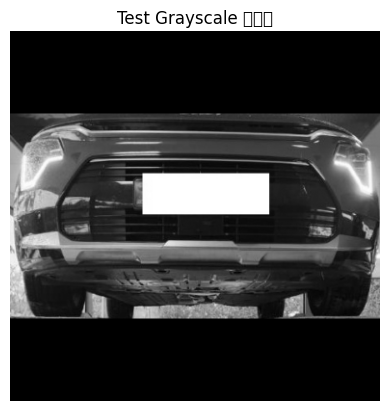

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 🚗 Test용 npy 파일 경로 (예시)
npy_path = '/content/drive/MyDrive/fuck/preprocessed_test/batch_000/TEST_00000.npy'

# npy 불러오기
img = np.load(npy_path)

# (1, H, W) → (H, W)
if img.shape[0] == 1:
    img = img.squeeze(0)

# 시각화
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Test Grayscale 시각화")
plt.show()


In [8]:
import os

# Test JPG 파일 수 확인
jpg_count = 0
jpg_paths = []

test_dir = '/content/drive/MyDrive/open/test'
for file in os.listdir(test_dir):
    if file.lower().endswith('.jpg'):
        jpg_count += 1
        jpg_paths.append(file)  # 파일명만 저장 (TEST_00000.jpg 등)

print(f"✅ Test 폴더 내 JPG 파일 수: {jpg_count}")

# 전처리된 .npy 파일 수 확인
npy_dir = '/content/drive/MyDrive/fuck/preprocessed_test'
npy_count = 0
npy_files = []

# 모든 하위 폴더까지 탐색
for root, dirs, files in os.walk(npy_dir):
    for file in files:
        if file.endswith('.npy'):
            npy_count += 1
            npy_files.append(os.path.join(root, file))

print(f"✅ 저장된 .npy 파일 수: {npy_count}")

# ⛔ 중복 또는 추가 파일 의심 확인
# jpg_paths = ['TEST_00000.jpg', ...] → 대응되는 npy는 'TEST_00000.npy'
expected_npy_names = set([os.path.splitext(f)[0] + '.npy' for f in jpg_paths])
actual_npy_names = set([os.path.basename(f) for f in npy_files])

extra = actual_npy_names - expected_npy_names
missing = expected_npy_names - actual_npy_names

if len(extra) == 0 and len(missing) == 0:
    print("✅ 모든 파일 정상! JPG ↔ npy 개수 및 이름 일치 🎉")
else:
    print(f"⚠️ 의심되는 추가 저장 파일 수: {len(extra)}")
    print("예시 파일 (extra):", list(extra)[:5])
    print(f"⚠️ 누락된 예상 파일 수: {len(missing)}")
    print("예시 파일 (missing):", list(missing)[:5])


✅ Test 폴더 내 JPG 파일 수: 8258
✅ 저장된 .npy 파일 수: 8258
✅ 모든 파일 정상! JPG ↔ npy 개수 및 이름 일치 🎉


In [9]:
import timm

model = timm.create_model('convnext_tiny', pretrained=True, num_classes=396)
print(model.default_cfg)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

{'url': '', 'hf_hub_id': 'timm/convnext_tiny.in12k_ft_in1k', 'architecture': 'convnext_tiny', 'tag': 'in12k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.95, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'stem.0', 'classifier': 'head.fc'}


In [10]:
print(model.default_cfg)


{'url': '', 'hf_hub_id': 'timm/convnext_tiny.in12k_ft_in1k', 'architecture': 'convnext_tiny', 'tag': 'in12k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.95, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'stem.0', 'classifier': 'head.fc'}


In [11]:
# ✅ 1️⃣ 모델 만들고 default_cfg 확인 (참고용)
model = timm.create_model(
    'convnext_tiny',
    pretrained=True,
    num_classes=396,
    in_chans=1
)

# 참고용 출력 (필수는 아님 — 그냥 확인)
print(model.default_cfg)

# ✅ 2️⃣ transform은 이미 내가 쓸 걸 정했음 (Grayscale + 384)
# 그대로 사용 (default_cfg에 mean/std가 있어도, 우리는 [0.5], [0.5] 씀 → 일치할 필요 없음)

# ✅ 3️⃣ DataLoader 구성 → 학습 시작


{'url': '', 'hf_hub_id': 'timm/convnext_tiny.in12k_ft_in1k', 'architecture': 'convnext_tiny', 'tag': 'in12k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'test_input_size': (3, 288, 288), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.95, 'test_crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'stem.0', 'classifier': 'head.fc'}


In [ ]:
import torch
import gc

def show_memory_status():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB 단위
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB 단위
    print(f"📊 현재 GPU 메모리 상태: Allocated = {allocated:.2f} MB | Reserved = {reserved:.2f} MB")

# 현재 CUDA 사용 가능 여부 확인
if torch.cuda.is_available():
    print("🔍 초기화 전 GPU 메모리 상태:")
    show_memory_status()

    # GPU 캐시 및 메모리 초기화
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

    print("\n🧹 GPU 메모리 초기화 완료")
    print("🔍 초기화 후 GPU 메모리 상태:")
    show_memory_status()
else:
    print("❌ CUDA 사용 불가")


🔍 초기화 전 GPU 메모리 상태:
📊 현재 GPU 메모리 상태: Allocated = 0.00 MB | Reserved = 0.00 MB

🧹 GPU 메모리 초기화 완료
🔍 초기화 후 GPU 메모리 상태:
📊 현재 GPU 메모리 상태: Allocated = 0.00 MB | Reserved = 0.00 MB


In [ ]:
import os
import glob

def extract_class_name(fname):
    # '1시리즈_F20_2013_2015_000123.npy' → '1시리즈_F20_2013_2015'
    return '_'.join(os.path.basename(fname).replace('.npy', '').split('_')[:-1])

all_npy_files = glob.glob('/content/drive/MyDrive/fuck/preprocessed/batch_*/**/*.npy', recursive=True)
class_names = sorted(set(extract_class_name(f) for f in all_npy_files))
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

print(f"클래스 수: {len(class_to_idx)}")  # 396개 나와야 정상


클래스 수: 396


In [ ]:
# # Dataset 클래스 정의

# import torch
# from torch.utils.data import Dataset
# import numpy as np

# class CarNPYDataset(Dataset):
#     def __init__(self, file_list, class_to_idx, transform=None):
#         self.file_list = file_list
#         self.class_to_idx = class_to_idx
#         self.transform = transform

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         path = self.file_list[idx]
#         image = np.load(path)  # (1, 384, 384)
#         image = torch.tensor(image, dtype=torch.float32)

#         class_name = '_'.join(os.path.basename(path).replace('.npy', '').split('_')[:-1])
#         label = self.class_to_idx[class_name]

#         if self.transform:
#             image = self.transform(image)

#         return image, label

import torch
from torch.utils.data import Dataset
import numpy as np
import os

class CarNPYDataset(Dataset):
    def __init__(self, file_list, class_to_idx, transform=None):
        self.file_list = file_list
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        image = np.load(path, mmap_mode='r')  # ✅ Lazy load
        image = torch.from_numpy(image).float()  # ✅ 빠른 tensor 변환

        # 파일명에서 클래스 추출
        class_name = '_'.join(os.path.basename(path).replace('.npy', '').split('_')[:-1])
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# 전체 .npy 파일 리스트 + train/val split + DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 전체 .npy 파일
file_list = glob.glob('/content/drive/MyDrive/fuck/preprocessed/batch_*/**/*.npy', recursive=True)

# 라벨 추출 → stratify 기반 split
labels = [class_to_idx[extract_class_name(f)] for f in file_list]
train_files, val_files = train_test_split(file_list, test_size=0.1, stratify=labels, random_state=42)

# transform
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale
])

# Dataset
train_dataset = CarNPYDataset(train_files, class_to_idx, transform)
val_dataset = CarNPYDataset(val_files, class_to_idx, transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor= 2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True,  persistent_workers=True, prefetch_factor= 2)


In [ ]:
import timm
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('convnext_tiny', pretrained=True, in_chans=1, num_classes=396)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
import copy
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(1, 31):
    print(f"\n🔁 Epoch {epoch}")

    # === 학습 ===
    model.train()
    train_loss = 0.0
    train_correct = 0

    loop = tqdm(train_loader, desc="Train", leave=False)
    for X, y in loop:
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        loop.set_postfix(loss=loss.item())

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # === 검증 ===
    model.eval()
    val_loss = 0.0
    val_correct = 0


    val_loop = tqdm(val_loader, desc="Valid", leave=False)
    with torch.no_grad():
        for X, y in val_loop:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * X.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_loop.set_postfix(loss=loss.item())

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    # === 로그 출력 ===
    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"✅ Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # === EarlyStopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "/content/drive/MyDrive/team_models/ConvNext-Tiny_progressing.pth")
        print("📦 Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⚠️ EarlyStopping patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# 최종 Best 모델 로드
model.load_state_dict(best_model_wts)



🔁 Epoch 1


Train:   0%|          | 0/466 [00:00<?, ?it/s]<ipython-input-7-433699da34eb>:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  image = torch.from_numpy(image).float()  # ✅ 빠른 tensor 변환
<ipython-input-7-433699da34eb>:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tenso

✅ Train Loss: 4.2181 | Acc: 0.2484
✅ Val   Loss: 0.6057 | Acc: 0.8500
📦 Best model saved!

🔁 Epoch 2


✅ Train Loss: 0.3054 | Acc: 0.9152
✅ Val   Loss: 0.2870 | Acc: 0.9228
📦 Best model saved!

🔁 Epoch 3


✅ Train Loss: 0.1008 | Acc: 0.9671
✅ Val   Loss: 0.2375 | Acc: 0.9363
📦 Best model saved!

🔁 Epoch 4


✅ Train Loss: 0.0678 | Acc: 0.9794
✅ Val   Loss: 0.1913 | Acc: 0.9490
📦 Best model saved!

🔁 Epoch 5


✅ Train Loss: 0.0478 | Acc: 0.9855
✅ Val   Loss: 0.2179 | Acc: 0.9454
⚠️ EarlyStopping patience: 1/3

🔁 Epoch 6


✅ Train Loss: 0.0487 | Acc: 0.9869
✅ Val   Loss: 0.2472 | Acc: 0.9418
⚠️ EarlyStopping patience: 2/3

🔁 Epoch 7


✅ Train Loss: 0.0578 | Acc: 0.9849
✅ Val   Loss: 0.2653 | Acc: 0.9357
⚠️ EarlyStopping patience: 3/3
⛔ Early stopping triggered.


<All keys matched successfully>

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
from PIL import Image
from torchvision import transforms

# 설정
MODEL_PATH = "/content/drive/MyDrive/team_models/ConvNext-Tiny_progressing.pth"
TEST_DIR = "/content/drive/MyDrive/open/test"
SAMPLE_SUB_PATH = "/content/drive/MyDrive/open/sample_submission.csv"
SAVE_SUBMISSION_PATH = "submission.csv"
NUM_CLASSES = 396

# 샘플 제출 파일에서 클래스명 추출
sample = pd.read_csv(SAMPLE_SUB_PATH)
column_names = sample.columns.tolist()[1:]  # 'ID' 제외

# ✅ 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('convnext_tiny', pretrained=False, in_chans=1, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# ✅ 이미지 transform (Grayscale + Resize + Normalize)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        pad_left = (max_wh - w) // 2
        pad_top = (max_wh - h) // 2
        padding = (pad_left, pad_top, max_wh - w - pad_left, max_wh - h - pad_top)
        return transforms.functional.pad(image, padding, fill=0)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    SquarePad(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ 테스트 Dataset
class TestDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.image_paths = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        fname = os.path.basename(path).replace(".jpg", "")
        return img, fname

# ✅ DataLoader
test_dataset = TestDataset(TEST_DIR, transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=4
)

# ✅ Inference
results = []
with torch.no_grad():
    for imgs, names in tqdm(test_loader, desc="🔍 Inference"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)

        for name, prob in zip(names, probs.cpu().numpy()):
            row = {"ID": name}
            row.update({class_name: prob[i] for i, class_name in enumerate(column_names)})
            results.append(row)

# ✅ 결과 저장
submission_df = pd.DataFrame(results)
submission_df = submission_df[["ID"] + column_names]
submission_df.to_csv(SAVE_SUBMISSION_PATH, index=False)

print(f"✅ 서브미션 저장 완료: {SAVE_SUBMISSION_PATH}")


🔍 Inference: 100%|██████████| 130/130 [01:17<00:00,  1.68it/s]


✅ 서브미션 저장 완료: submission.csv


In [ ]:
df = pd.read_csv("/content/submission.csv")
df.to_csv("submission_utf8sig.csv", index=False, encoding='utf-8-sig')


In [ ]:
print(f"테스트 파일 개수: {len(test_files)}")
print(test_files[:3])  # 앞 몇 개 파일 이름 확인


테스트 파일 개수: 0
[]


In [ ]:
# 테스트용 파일 불러오기
import numpy as np

test_path = "/content/drive/MyDrive/fuck/preprocessed/batch_000/1시리즈_F20_2013_2015_000000.npy"
with open(test_path, "rb") as f:
    print(f.read(10))  # 처음 몇 바이트를 출력 (정상 npy면 b'\x93NUMPY'로 시작)

b'\x93NUMPY\x01\x00v\x00'


In [ ]:
from pathlib import Path

broken = []

for npy_file in Path("/content/drive/MyDrive/fuck/preprocessed").rglob("*.npy"):
    try:
        np.load(str(npy_file), allow_pickle=False)
    except Exception as e:
        print(f"❌ {npy_file} - {e}")
        broken.append(npy_file)

print(f"\n손상된 파일 수: {len(broken)}")



손상된 파일 수: 0


In [ ]:
import os
import numpy as np

def is_npy_file_valid(path):
    try:
        # allow_pickle=False로 먼저 시도
        _ = np.load(path, allow_pickle=False)
        return True
    except ValueError as e:
        # pickle 관련 오류만 있을 경우 allow_pickle=True로 재시도
        if "pickled data" in str(e):
            try:
                _ = np.load(path, allow_pickle=True)
                return True
            except Exception:
                return False
        else:
            return False
    except Exception:
        return False

# 검사할 경로
base_dir = "/content/drive/MyDrive/fuck/preprocessed"

# 모든 npy 파일 경로 수집
corrupted_files = []
total_files = 0

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".npy"):
            path = os.path.join(root, file)
            total_files += 1
            if not is_npy_file_valid(path):
                corrupted_files.append(path)

# 결과 출력
print(f"총 검사한 파일 수: {total_files}")
print(f"❌ 손상된 파일 수: {len(corrupted_files)}")
if corrupted_files:
    print("예시 손상 파일:")
    for path in corrupted_files[:5]:
        print(" -", path)


총 검사한 파일 수: 33138
❌ 손상된 파일 수: 0


In [ ]:
broken_path = "/content/drive/MyDrive/fuck/preprocessed/batch_000/1시리즈_F20_2013_2015_000000.npy"


In [ ]:
import os

filename = os.path.basename(broken_path)
parts = filename.replace(".npy", "").split("_")
class_name = "_".join(parts[:-1])
index = parts[-1]
print(f"class_name: {class_name}, index: {index}")


class_name: 1시리즈_F20_2013_2015, index: 000000


In [ ]:
original_image_path = f"/content/drive/MyDrive/open/train/{class_name}"
print("해당 클래스 폴더 경로:", original_image_path)

# 해당 클래스 안에서 몇 번째 이미지인지 찾아야 함
import os

# 숫자 인덱스는 앞에서 몇 번째인지 알 수 있게 순서대로 접근
images = sorted(os.listdir(original_image_path))
target_image_name = images[int(index)]
print("대상 원본 이미지 이름:", target_image_name)


해당 클래스 폴더 경로: /content/drive/MyDrive/open/train/1시리즈_F20_2013_2015
대상 원본 이미지 이름: 1시리즈_F20_2013_2015_0000.jpg


In [ ]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision.transforms import functional as TF

# 전처리 transform 정의
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        pad_left = (max_wh - w) // 2
        pad_top = (max_wh - h) // 2
        padding = (pad_left, pad_top, max_wh - w - pad_left, max_wh - h - pad_top)
        return TF.pad(image, padding, fill=0)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    SquarePad(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 이미지 열기
img_path = os.path.join(original_image_path, target_image_name)
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img)

# 안전하게 저장 (astype으로 pickle 방지)
np.save(broken_path, img_tensor.numpy().astype(np.float32))
print("✅ 다시 저장 완료:", broken_path)


✅ 다시 저장 완료: /content/drive/MyDrive/fuck/preprocessed/batch_000/1시리즈_F20_2013_2015_000000.npy
